In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import cv2

plt.ion()   # interactive mode

In [2]:
%matplotlib inline

In [3]:
# Data preprocessing (data augmentation and normalisation)

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
# Before proceeding make sure the data is split into train and val.
# In this case the data is split into 125 train and 75 test following the
# hymenoptera dataset split.

In [4]:
data_dir = '../data/tank_data_hole/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                         data_transforms[x])
                 for x in ['train', 'val']}

In [5]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                        shuffle = True, num_workers = 4)
              for x in ['train', 'val']}

In [6]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [7]:
class_names = image_datasets['train'].classes

In [8]:
class_names

['CT100', 'Platina', 'Pulsar', 'V']

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
device

device(type='cuda', index=0)

In [12]:
# Function to train the model and return the model with the best pred wieghts

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-'*10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc >= best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time()-since
    print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [13]:
# Function to diplay predictions of a few images

def visualize_model(model, num_images = 6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [14]:
# Finetuning the convnet 

# model_ft = models.resnet18(pretrained=True)
# num_ftrs = model_ft.fc.in_features

# model_ft.fc = nn.Linear(num_ftrs, 2)

# model_ft = model_ft.to(device)

# criterion = nn.CrossEntropyLoss()

# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [15]:
# model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
#                        num_epochs=25)

In [16]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 4)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [17]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler,
                      num_epochs=25)

Epoch 0/24
----------
train Loss: 1.0578 Acc: 0.5138
val Loss: 0.2276 Acc: 1.0000

Epoch 1/24
----------
train Loss: 0.6923 Acc: 0.7202
val Loss: 0.0773 Acc: 1.0000

Epoch 2/24
----------
train Loss: 0.5537 Acc: 0.7936
val Loss: 0.0548 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.8195 Acc: 0.7339
val Loss: 0.0312 Acc: 1.0000

Epoch 4/24
----------
train Loss: 0.3845 Acc: 0.8716
val Loss: 0.0103 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.3783 Acc: 0.8670
val Loss: 0.0062 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.4008 Acc: 0.8716
val Loss: 0.0247 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.3408 Acc: 0.8532
val Loss: 0.0082 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.3037 Acc: 0.9174
val Loss: 0.0052 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.3178 Acc: 0.8807
val Loss: 0.0050 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.2836 Acc: 0.9037
val Loss: 0.0051 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.3517 Acc: 0.8716
val Loss: 0.0065 Acc: 1.0000

Ep

In [21]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

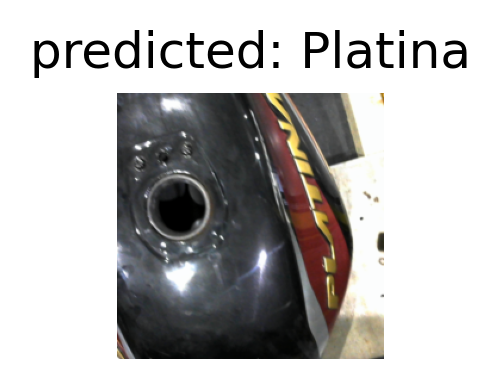

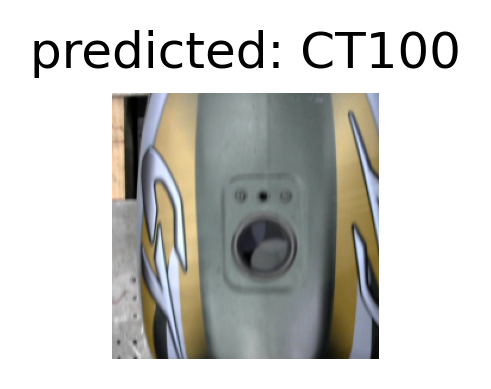

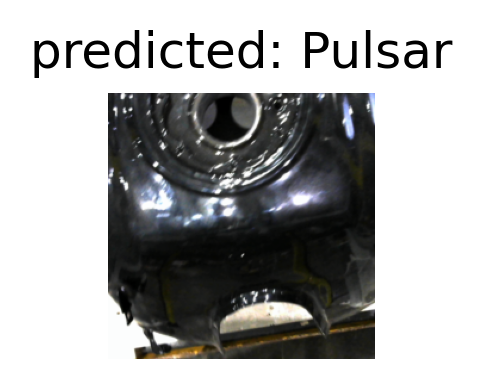

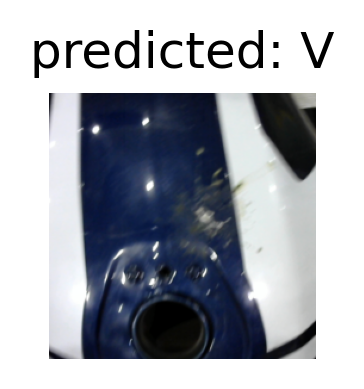

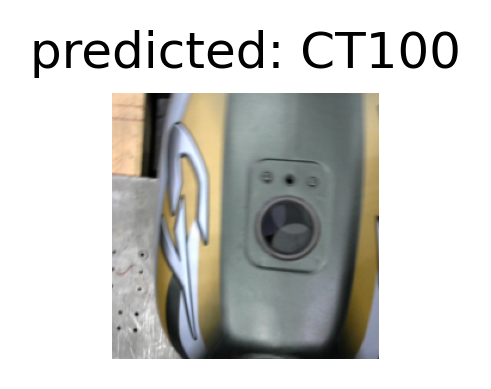

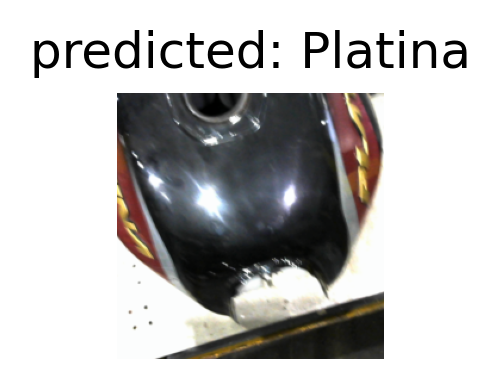

In [19]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
visualize_model(model_conv)

In [20]:
torch.save(model_conv.state_dict(), "tank_models_hole.pth")